In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2,joblib,glob,os
from imutils.object_detection import non_max_suppression
import imutils
from skimage.feature import hog
from skimage import color
from skimage.transform import pyramid_gaussian
import argparse
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = os.path.join('/content/drive','MyDrive/Đồ án CV/')
test_image_dir = os.path.join(root_dir, 'Test Dataset')
test_annotations_dir = os.path.join(root_dir, 'Test Annotations', 'annotations.json')

In [ ]:
model = joblib.load(os.path.join(root_dir, 'models.dat'))

In [ ]:
with open(test_annotations_dir) as file:
  test_annotations = json.load(file)

In [ ]:
test_image_filenames = os.listdir(test_image_dir)
test_images = []

for filename in test_image_filenames:
  test_images.append(os.path.join(test_image_dir, filename))

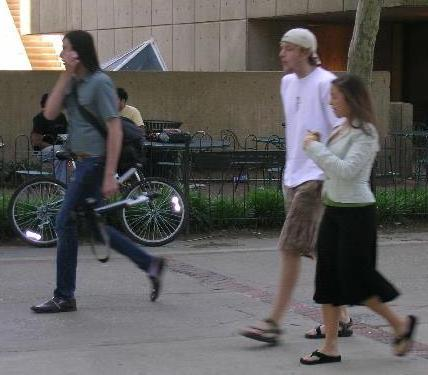

In [ ]:
cv2_imshow(cv2.imread(test_images[0]))

In [ ]:
def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

In [ ]:
size = (64,128)
step_size = (9,9)
downscale = 1.25

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# import the necessary packages
import numpy as np

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked
	return boxes[pick].astype("int"), probs[pick]

In [ ]:
def hog_svm_detection(filepath):
    image = cv2.imread(filepath)
    # image = cv2.resize(image, (300, 200))
    detections = []
    scale = 0

    for im_scaled in pyramid_gaussian(image, downscale = downscale):
        if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
            break
        for (x, y, window) in sliding_window(im_scaled, size, step_size):
            if window.shape[0] != size[1] or window.shape[1] != size[0]:
                continue
            window = color.rgb2gray(window)

            fd=hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)

            if pred == 1:
                if sigmoid(model.decision_function(fd)[0]) > 0.7:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), sigmoid(model.decision_function(fd)[0]),
                    int(size[0] * (downscale**scale)),
                    int(size[1] * (downscale**scale))))

        scale += 1
    clone = image.copy()
    rects = np.array([[x, y, score, x + w, y + h] for (x, y, score, w, h) in detections])
    sc = [score for (_, _, score, _, _) in detections]
    sc = np.array(sc)
    # print(rects)
    pick, sc_pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.1)
    # for(x1, y1, x2, y2) in pick:
    #     cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
    #     cv2.putText(clone,'Pedestrian',(x1-2,y1-2),1,0.75,(255,255,0),1)
    # print(pick)
    # print(sc_pick)

    return pick, sc_pick

In [ ]:
import numpy as np
import warnings

def calculate_iou(box1, box2):
    """Calculate the intersection over union (IoU) of two bounding boxes."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection = max(0, min(x1 + w1, x2 + w2) - max(x1, x2)) * max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    union = w1 * h1 + w2 * h2 - intersection

    return intersection / union

def calculate_ap(recall, precision):
    """Calculate the average precision (AP) from precision-recall curve."""
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def calculate_map(ground_truth, predicted_boxes, confidence_scores, iou_threshold=0.5):
    """Calculate the mean Average Precision (mAP) for object detection."""
    sorted_indices = np.argsort(-confidence_scores)
    sorted_boxes = predicted_boxes[sorted_indices]
    num_detections = len(sorted_boxes)

    true_positives = np.zeros(num_detections)
    false_positives = np.zeros(num_detections)
    ground_truth_boxes = len(ground_truth)

    for detection_idx, detection_box in enumerate(sorted_boxes):
        iou_max = 0
        detected_idx = -1

        for idx, ground_truth_box in enumerate(ground_truth):
            iou = calculate_iou(detection_box, ground_truth_box)
            if iou > iou_max:
                iou_max = iou
                detected_idx = idx
        if iou_max >= iou_threshold and detected_idx >= 0:
            if true_positives[detected_idx] == 0:
                true_positives[detected_idx] = 1
            else:
                false_positives[detection_idx] = 1
        else:
            false_positives[detection_idx] = 1
    cumsum = np.cumsum(true_positives)
    recall = cumsum / ground_truth_boxes
    precision = cumsum / (cumsum + np.cumsum(false_positives))
    ap = calculate_ap(recall, precision)
    return ap

In [ ]:
mAP_scores = []

In [ ]:
warnings.filterwarnings("ignore")

for index, item in enumerate(test_images):
  print(index)
  detections = hog_svm_detection(item)
  predicted_boxes = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections[0]])
  confidence_scores = np.array(detections[1])
  ground_truth = np.array(test_annotations[index]['boxes'])
  # print(predicted_boxes)
  # print(ground_truth)
  # print(confidence_scores)

  mAP = calculate_map(ground_truth, predicted_boxes, confidence_scores)
  print(mAP)
  mAP_scores.append(mAP)

In [ ]:
# Tính trung bình mAP của toàn bộ tập test
mean_mAP = np.mean(mAP_scores)
print("Mean Average Precision (mAP):", mean_mAP)

Mean Average Precision (mAP): 0.2712572798903734


In [ ]:
def visualizing(filepath, ground_truth):
    image = cv2.imread(filepath)
    # image = cv2.resize(image, (300, 200))
    detections = []
    scale = 0

    for im_scaled in pyramid_gaussian(image, downscale = downscale):
        if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
            break
        for (x, y, window) in sliding_window(im_scaled, size, step_size):
            if window.shape[0] != size[1] or window.shape[1] != size[0]:
                continue
            window = color.rgb2gray(window)

            fd=hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)

            if pred == 1:
                if sigmoid(model.decision_function(fd)[0]) > 0.7:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), sigmoid(model.decision_function(fd)[0]),
                    int(size[0] * (downscale**scale)),
                    int(size[1] * (downscale**scale))))

        scale += 1
    clone = image.copy()
    rects = np.array([[x, y, score, x + w, y + h] for (x, y, score, w, h) in detections])
    sc = [score for (_, _, score, _, _) in detections]
    sc = np.array(sc)

    pick, sc_pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.1)
    for(x1, y1, x2, y2) in ground_truth:
        cv2.rectangle(clone, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    for(x1, y1, _, x2, y2) in pick:
        cv2.rectangle(clone, (x1, y1), (x2, y2), (255, 0, 0), 2)

    fig, ax = plt.subplots(1)
    ax.imshow(clone)

    plt.show()